# Integration of Multiple Technologies

There are different technologies to obtain multi-channel images: CODEX, Imaging Mass Cytometry (IMC), MACSima imaging cyclic staining (MICS), MIBI, etc.
This notebook explores how you can use `spatialproteomics` to jointly analyse multiple modalities.

## Data Origin
The IMC data was downloaded from [here](https://figshare.com/articles/dataset/Raw_images_for_DLBCL_samples/20010146?file=35633237). It contains IMC images of DLBCL TMAs.

MICS data was downloaded from [here](https://zenodo.org/records/10057717). It contains a tonsil sample.

A link to the CODEX data can be found in the `spatialproteomics` manuscript.

## Data Preparation

For all three data modalities, we follow the same workflow of segmentation, protein quantification, and cell type prediction. Our downstream analysis is then carried out on the cell type level. This means that our data does not even need to have the same markers, as long as we can identify the same cell types with them.

In [1]:
import xarray as xr
import spatialproteomics as sp
from glob import glob
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


celltype_colors = {
    "B cell": "#5799d1",
    "T cell": "#ebc850",
    "Myeloid cell": "#de6866",
    "Dendritic cell": "#4cbcbd",
    "Macrophage": "#bb7cb4",
    "Stromal cell": "#62b346",
    "Endothelial cell": "#bf997d",
}

### Imaging Mass Cytometry (IMC)

For the IMC data, we have a diffuse large B cell lymphoma (DLBCL) sample. The data is comprised of individual tiff files (one per marker), as well as a tiff file containing a segmentation that was performed with `ilastik`. The first step is to read this data into `spatialproteomics`.

In [2]:
def read_imc_data(path):
    # === DATA READING ===
    images = []
    markers = []
    for file in glob(path + "*.tiff"):
        if "ilastik" in file:
            continue
        marker_name = file.split("/")[-1].replace(".tiff", "")
        images.append(tifffile.imread(file))
        markers.append(marker_name)
    image = np.stack(images)

    segmentation = tifffile.imread(path + "DLBCL TMA #5_1_3964_1_a0_ilastik_s2_Probabilities_mask.tiff")

    # === CONVERTING TO SPATIALPROTEOMICS ===
    ds_imc = sp.load_image_data(image, channel_coords=markers, segmentation=segmentation)
    return ds_imc


ds_imc = read_imc_data("../../data/raw-ablated-files/3964_DLBCL TMA #5_1_3964_1/")

Now that we have a dataset, we can look at the markers.

In [3]:
ds_imc["channels"].values

array(['Histone3.Yb176Di', 'DNA.Ir193Di', 'CD45RA.Gd155Di',
       'Vimentin.Nd143Di', 'Ki67.Er168Di', 'Membrane.In115Di',
       'Tim3.Sm154Di', 'ICOS.Nd148Di', 'PD1.NAT105..Lu175Di',
       'EphrinB2.Er166Di', 'CD20.Dy161Di', 'BCL2.Nd146Di', 'BCL6.Sm147Di',
       'FOXP3.Dy163Di', 'Vista.Dy160Di', 'Lag3.Eu153Di', 'C.Myc.Dy164Di',
       'CD3.Er170Di', 'p.Stat3.Gd158Di', 'CD134.Eu151Di', 'CCR4.Sm149Di',
       'CD206.Tm169Di', 'DNA2.Ir191Di', 'CXCR3.Nd142Di', 'CD68.Tb159Di',
       'Granzym.B.Er167Di', 'CD45RO.Yb173Di', 'CD8.Dy162Di',
       'PDL1.Nd150Di', 'CD4.Gd156Di', 'CD30.Ho165Di', 'Tbet.Nd145Di',
       'CD31.Nd144Di', 'HLADR.Yb174Di', 'PDL2.Yb172Di'], dtype='<U19')

We can now use these markers to predict cell types. This step involves thresholding the different channels. After thresholding, you should always ensure that your cell type labels look sensible.

In [4]:
marker_to_celltype = {
    "CD20.Dy161Di": "B cell",
    "CD3.Er170Di": "T cell",
    "CD31.Nd144Di": "Endothelial cell",
    "CD68.Tb159Di": "Macrophage",
    "Vimentin.Nd143Di": "Stromal cell",
    "HLADR.Yb174Di": "Dendritic cell",
}

marker_to_color = {k: celltype_colors.get(v) for k, v in marker_to_celltype.items()}

threshold_dict = {
    "CD20.Dy161Di": 0.5,
    "CD3.Er170Di": 0.5,
    "CD31.Nd144Di": 0.8,
    "CD68.Tb159Di": 0.8,
    "Vimentin.Nd143Di": 0.8,
    "HLADR.Yb174Di": 0.95,
}

ds_imc = (
    ds_imc.pp.threshold(quantile=threshold_dict.values(), channels=threshold_dict.keys())
    .pp.add_quantification(func="intensity_mean")
    .pp.transform_expression_matrix(method="arcsinh")
    .la.predict_cell_types_argmax(marker_to_celltype)
    .la.set_label_colors(celltype_colors.keys(), celltype_colors.values())
)

Label Myeloid cell not found in the data object. Skipping.


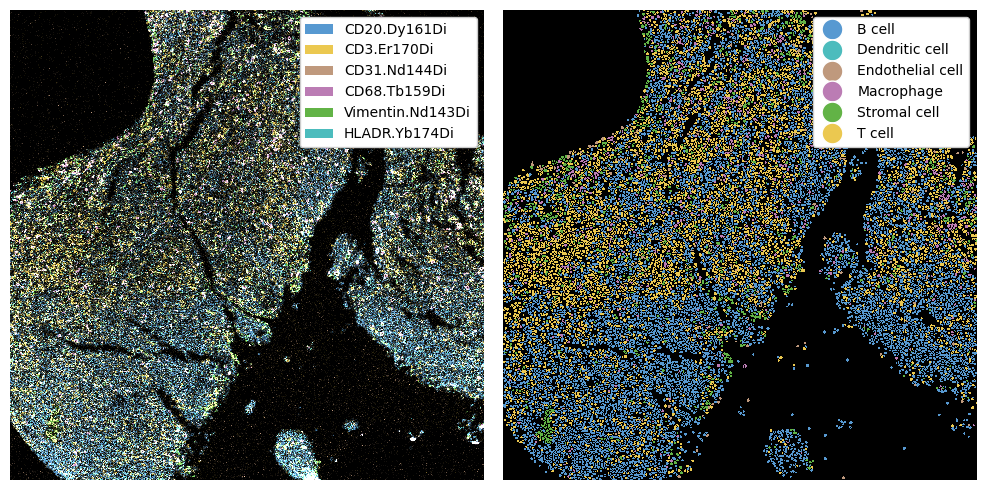

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = ds_imc.pp[marker_to_color.keys()].pl.colorize(marker_to_color.values()).pl.show(ax=ax[0])
_ = ds_imc.pl.show(render_image=False, render_labels=True, ax=ax[1])
for axis in ax:
    axis.axis("off")
plt.tight_layout()
plt.show()

### MACSima imaging cyclic staining (MICS)
For MICS, we have a tonsil sample with high resolution. To illustrate how you can use `spatialproteomics` across different methods, we use `mesmer` to segment the cells based on DAPI and CD45.

In [6]:
def read_mics_data(path):
    # === DATA READING ===
    images = []
    markers = []

    image_shape = (7253, 9182)
    for file in glob(path + "*.tif"):
        marker_name = file.split("/")[-1].split("ROI-21_A-")[-1].replace(".tif", "")
        img = tifffile.imread(file)
        if img.shape != image_shape:
            print(f"The image for marker {marker_name} had shape {img.shape}, expected {image_shape}. Continuing...")
            continue
        if marker_name in markers:
            print(f"Already found marker {marker_name}, continuing...")
            continue
        images.append(img)
        markers.append(marker_name)

    image = np.stack(images)
    del images

    # === CONVERTING TO SPATIALPROTEOMICS ===
    ds_mics = sp.load_image_data(image, channel_coords=markers)
    return ds_mics


ds_mics = read_mics_data("../../data/Tonsil 2 - processed images/")

The image for marker AFP had shape (7060, 9184), expected (7253, 9182). Continuing...
Already found marker PE, continuing...
Already found marker FITC, continuing...


In [ ]:
# downsampling the image for faster runtime
ds_mics = ds_mics.pp.downsample(8).tl.mesmer(channel=["DAPI", "CD45"])

2025-09-09 14:22:48.686211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /g/huber/users/meyerben/.conda/envs/tmp_env_3/lib/python3.10/site-packages/cv2/../../lib64:
2025-09-09 14:22:48.686243: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Next, we can once again predict cell types. While our markers are different now, our celltypes are still the same. This means that we can still compare things such as cell type abundances and cell-cell interactions later, assuming our cell type predictions are sensible for all technologies.

In [ ]:
marker_to_celltype = {
    "CD20": "B cell",
    "CD3": "T cell",
    "CD31": "Endothelial cell",
    "CD163": "Macrophage",
    "CD1c_C-BDCA1": "Dendritic cell",
    "CD11b": "Myeloid cell",
    "Vimentin": "Stromal cell",
}

marker_to_color = {k: celltype_colors.get(v) for k, v in marker_to_celltype.items()}

threshold_dict = {
    "CD20": 0.5,
    "CD3": 0.5,
    "CD31": 0.9,
    "CD163": 0.7,
    "CD1c_C-BDCA1": 0.9,
    "CD11b": 0.7,
    "Vimentin": 0.98,
}

ds_mics = (
    ds_mics.pp.threshold(quantile=threshold_dict.values(), channels=threshold_dict.keys())
    .pp.add_quantification(func="intensity_mean")
    .pp.transform_expression_matrix(method="arcsinh")
    .la.predict_cell_types_argmax(marker_to_celltype)
    .la.set_label_colors(celltype_colors.keys(), celltype_colors.values())
)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = ds_mics.pp[marker_to_color.keys()].pl.colorize(marker_to_color.values()).pl.show(ax=ax[0])
_ = ds_mics.pl.show(render_image=False, render_labels=True, ax=ax[1])
for axis in ax:
    axis.axis("off")
plt.tight_layout()
plt.show()

### CODEX
This CODEX sample shows a DLBCL. It was segmented with `cellpose`, meaning that our three technologies were all segmented with different methods. In addition, it does not have the same markers as the other datasets, but the predicted cell types are the same.

In [ ]:
marker_to_celltype = {
    "PAX5": "B cell",
    "CD3": "T cell",
    "CD11b": "Myeloid cell",
    "CD68": "Macrophage",
    "CD11c": "Dendritic cell",
    "CD90": "Stromal cell",
    "Podoplanin": "Stromal cell",
    "CD31": "Endothelial cell",
    "CD34": "Endothelial cell",
}

marker_to_color = {k: celltype_colors.get(v) for k, v in marker_to_celltype.items()}

ds_codex = (
    xr.open_zarr("../../data/DLBCL_21_1.zarr")
    .la.set_label_level("labels_0", ignore_neighborhoods=True)
    .la.set_label_colors(celltype_colors.keys(), celltype_colors.values())
)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = ds_codex.pl.autocrop().pp[marker_to_color.keys()].pl.colorize(marker_to_color.values()).pl.show(ax=ax[0])
_ = ds_codex.pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[1])
for axis in ax:
    axis.axis("off")
plt.tight_layout()
plt.show()

## Comparing cell type abundances

In [ ]:
# Get counts for each modality
counts_imc = ds_imc.pp.get_layer_as_df()["_labels"].value_counts()
counts_mics = ds_mics.pp.get_layer_as_df()["_labels"].value_counts()
counts_codex = ds_codex.pp.get_layer_as_df()["_labels"].value_counts()

# Put into one dataframe
df = pd.DataFrame({"IMC (DLBCL)": counts_imc, "MICS (Tonsil)": counts_mics, "CODEX (DLBCL)": counts_codex}).fillna(0)

# Convert to relative abundances (fractions per modality)
df_rel = df.div(df.sum(axis=0), axis=1)

# Reshape into long format for seaborn
df_rel = (
    df_rel.reset_index()
    .melt(
        id_vars="_labels",
        value_vars=["IMC (DLBCL)", "MICS (Tonsil)", "CODEX (DLBCL)"],
        var_name="Modality",
        value_name="Relative Abundance",
    )
    .rename(columns={"_labels": "CellType"})
)

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_rel, x="CellType", y="Relative Abundance", hue="Modality")

plt.xticks(rotation=90, ha="center")
plt.xlabel("Cell Type")
sns.despine()
plt.tight_layout()
plt.show()